# Fashion MNIST: Exploratory Analysis
This notebook will walk through some exploratory techniques in order to gain familiarity with the Fashion MNIST dataset.

The techniques we'll demonstrate include:
* Basic averaging over class categories
* Distributional analysis of pixel intensity
* Image symmetry 
* Dimensionality reduction and projection with PCA and UMAP

In [ ]:
!pip install umap-learn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split

In [ ]:
(x_dev, y_dev), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_valid, y_train, y_valid = train_test_split(x_dev, y_dev, 
                                                      random_state=7699,
                                                      test_size=10_000)

del x_dev, y_dev

In [ ]:
print(f"{x_train.shape[0]:,} rows in training")
print(f"{x_valid.shape[0]:,} rows in validation")
print(f"{x_test.shape[0]:,} rows in test")

50,000 rows in training
10,000 rows in validation
10,000 rows in test


For this analysis, we will only use the training set. The dictionary below converts the integer labels into class names, which we'll use for easier reading.

In [ ]:
label_map = {
  0:	'T-shirt/top',
  1:	'Trouser',
  2:	'Pullover',
  3:	'Dress',
  4:	'Coat',
  5:	'Sandal',
  6:	'Shirt',
  7:	'Sneaker',
  8:	'Bag',
  9:	'Ankle boot'
}

In [ ]:
y_train_names = pd.Series(y_train).map(label_map).values
y_train_names[:10]

array(['Pullover', 'T-shirt/top', 'Dress', 'Dress', 'Pullover',
       'T-shirt/top', 'Sandal', 'Trouser', 'Shirt', 'Dress'], dtype=object)

We generally scale input images between 0 and 1. Let's do that now

In [ ]:
x_train = x_train / 255.
x_valid = x_valid / 255.
x_test = x_test / 255.

Let's see the distribution of classes.

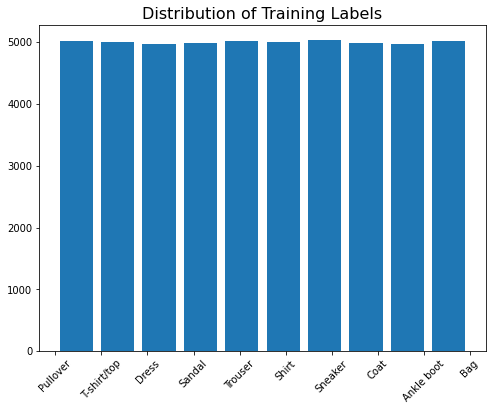

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(y_train_names, rwidth=0.8)
plt.title("Distribution of Training Labels", fontsize=16)
plt.xticks(rotation=45)
plt.show()

## Pixel Intensity

These grayscale Fashion MNIST images are represented by pixel intensity. We can explore the spatial average pixel intensity and aggregate distributional differences to get a feel for how the classes relate to each other.

### Distributions
We can start by showing how dark/bright are images are by averaging the 28x28 pixel values over each image. Values closer to 1 will have higher intensity, meaning that the image is nearly filled in entirely. Values closer to 0 will have fewer pixels shaded (or uniformly low-intensity pixels).

In [ ]:
image_averages = x_train.mean(axis=(1,2))
image_averages.shape

(50000,)

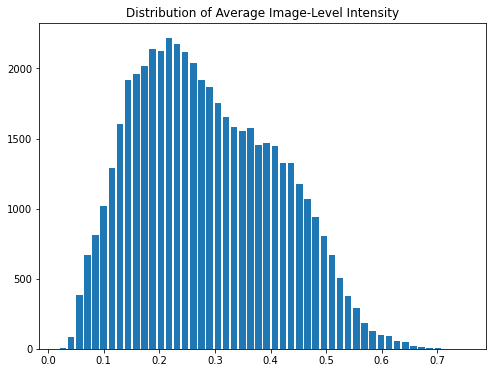

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(image_averages, rwidth=0.8, bins=50)
plt.title("Distribution of Average Image-Level Intensity")
plt.show()

Let's see how this differs by class.

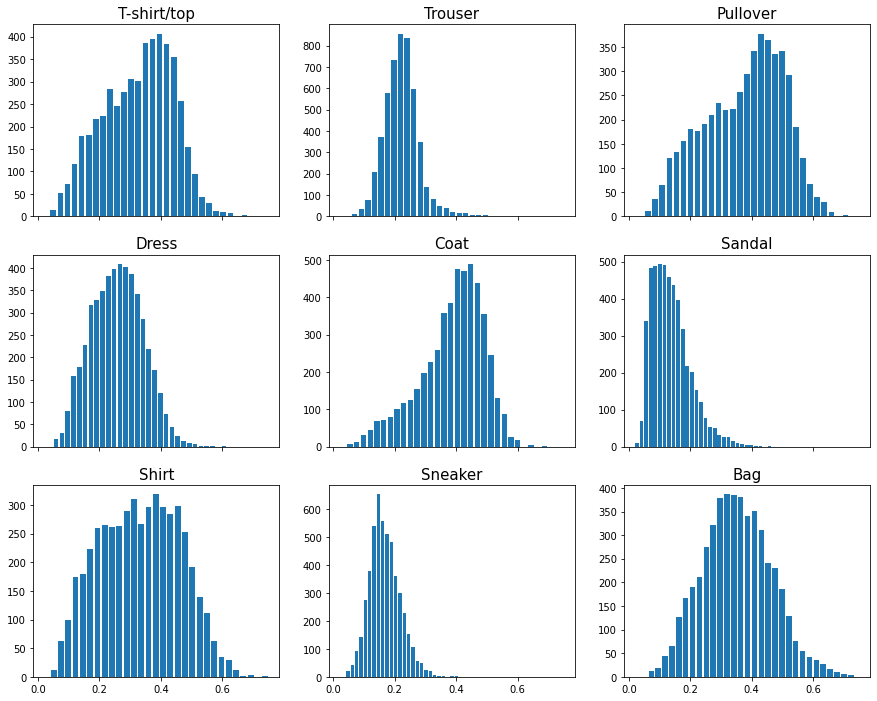

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 12), sharex=True)
this_label_idx = 0
for row in range(3):
  for col in range(3):
    this_group = x_train[y_train == this_label_idx].mean(axis=(1,2))
    ax[row][col].hist(this_group, rwidth=0.8, bins=30)
    ax[row][col].set_title(label_map[this_label_idx], fontsize=15)
    this_label_idx += 1

plt.show()

This is quite interesting - we can see that sandals and sneakers tend to skew darker, while pullovers and t-shirt/top have similarly shaped ligher distributions. Shirts have an interesting distribution as well. Let's look at a more aggregated view.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


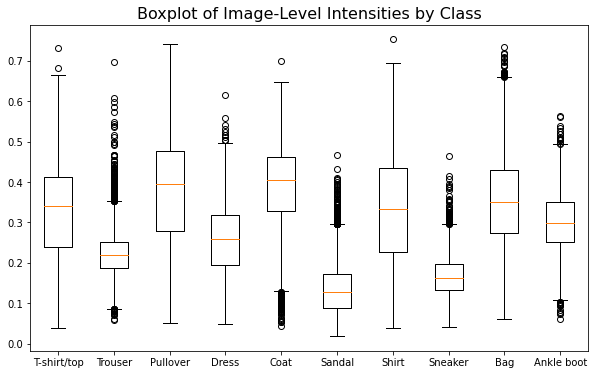

In [ ]:
boxplot_data = [x_train[y_train_names == name].mean(axis=(1,2)) for name in label_map.values()]

plt.figure(figsize=(10, 6))
plt.boxplot(boxplot_data, labels=list(label_map.values()))
plt.title("Boxplot of Image-Level Intensities by Class", fontsize=16)
plt.show()

Awesome. 

### Image Prototypes
We can also perform an average of each pixel's value over each class to see a "prototypical" version of each category in the training set.

In [ ]:
prototypes = [x_train[y_train_names == name].mean(0) for name in label_map.values()]

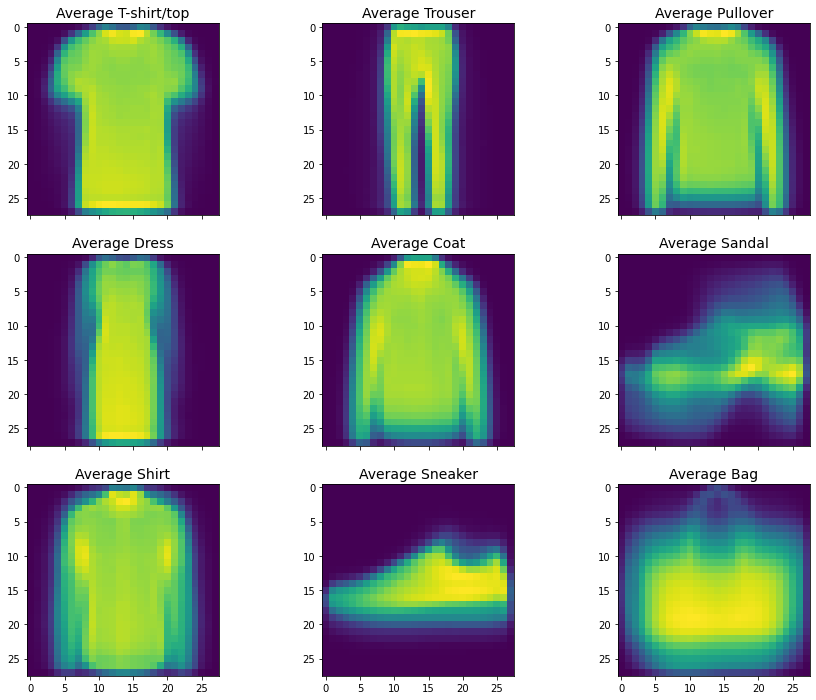

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 12), sharex=True)
this_label_idx = 0
for row in range(3):
  for col in range(3):
    ax[row][col].imshow(prototypes[this_label_idx])
    ax[row][col].set_title(f"Average {label_map[this_label_idx]}", fontsize=14)
    this_label_idx += 1

plt.show()

From this, we can see some of the features that make up each class: we can see the sleeves of a coat, the trouser legs, and the handle of the bag. We can also see that there is quite a bit of variety in sandals, and that shirts and dresses may or may not have sleeves.

From here, we can start to gain expectations and form hypotheses about how we'll need to approach the modeling task. For example, the `Shirt` and `T-shirt/top` classes seem to overlap to some degree. We should keep an eye on this as we start to model. 

### Average Symmetry
We can also approximate how symmetric an image is by taking the absolute value of the difference between a horizontally flipped image and the original. The `numpy` function `fliplr` can help us with this.

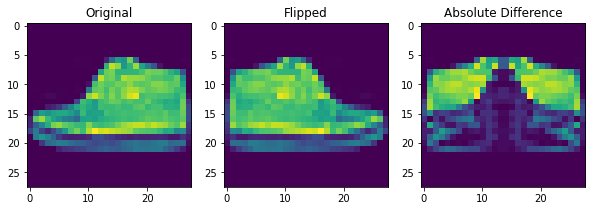

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

idx = 10
original = x_train[idx]
flipped = np.fliplr(x_train[idx])
diff = np.abs(original - flipped)

ax[0].imshow(original)
ax[0].set_title("Original")
ax[1].imshow(flipped)
ax[1].set_title("Flipped")
ax[2].imshow(diff)
ax[2].set_title("Absolute Difference")


plt.show()

For this shoe, the space above the toe is the highlighted region. For more asymmetric images, there will be more highlighted pixels in the difference, so averaging the absolute difference will give us a rough quantification of the symmetry of each image.

In [ ]:
all_diffs = np.abs(x_train - x_train[:, :, ::-1]).mean(axis=(1, 2))
all_diffs.shape

(50000,)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


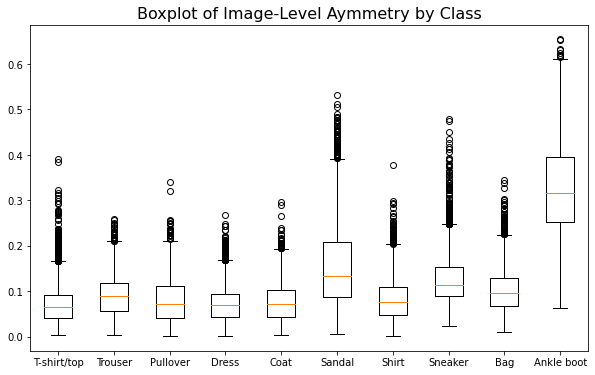

In [ ]:
sym_boxplot_data = [all_diffs[y_train_names == name] for name in label_map.values()]

plt.figure(figsize=(10, 6))
plt.boxplot(sym_boxplot_data, labels=list(label_map.values()))
plt.title("Boxplot of Image-Level Aymmetry by Class", fontsize=16)
plt.show()

## 2D Projections

### Principal Components
PCA allows us to decompose images into "components" made up of linear combination of features. We will flatten each image into a vector (where each pixel is a feature) and use the first two principal components to plot a 2D projection of the dataset. This will help illustrate the "spread" of the data in linear feature space.

In [ ]:
x_train_flattened = x_train.reshape((x_train.shape[0], -1))
x_train_flattened.shape

(50000, 784)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [ ]:
x_pca = PCA(n_components=2).fit_transform(x_train_flattened)

In [ ]:
pca_centers = {}
for yval in label_map.values():
  pca_centers[yval] = x_pca[y_train_names == yval].mean(0)

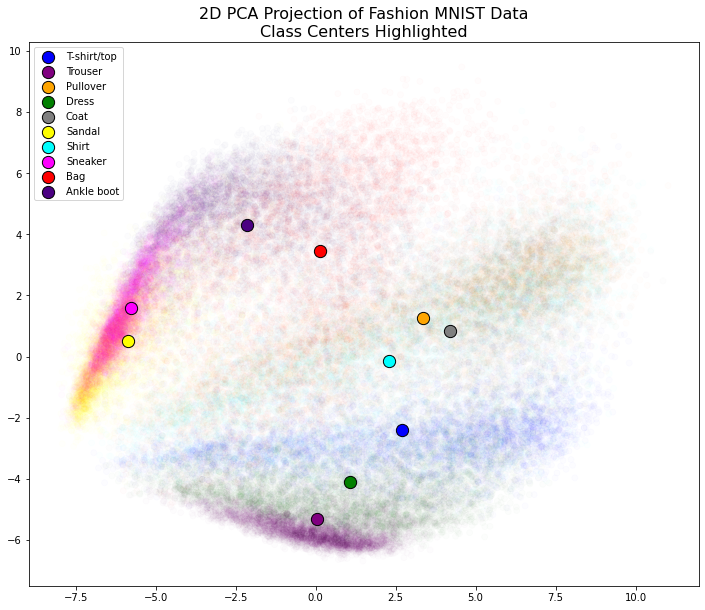

In [ ]:
color_map = {
    'T-shirt/top':'blue',
     'Trouser':'purple', 
     'Pullover':'orange', 
     'Dress':'green', 
     'Coat':'gray', 
     'Sandal':'yellow', 
     'Shirt':'cyan',
     'Sneaker':'magenta', 
     'Bag':'red', 
     'Ankle boot':'indigo'
}

plt.figure(figsize=(12, 10))
plt.scatter(x_pca[:, 0], x_pca[:, 1], alpha=0.01, c=pd.Series(y_train_names).map(color_map))
for yval, (x, y) in pca_centers.items():
  plt.scatter(x, y, s=150, c=color_map[yval], edgecolors='black', label=yval)
plt.legend()
plt.title("2D PCA Projection of Fashion MNIST Data\nClass Centers Highlighted", fontsize=16)
plt.show()

We can see that there is a decent amount of spread between classes - for example, trousers (lower center) are quite different from sneakers and sandals (center left). We can also see some of the similarities and overlap between classes.

### UMAP
Similarly to PCA, UMAP performs a decomposition of high-dimensional data into low-dimensional components. UMAP does this via a topological approach, where a local graph is constructed for each "neighborhood" of points in the original feature space. This technique is called manifold learning, and it provides a method of capturing more complex nonlinear relationships.

More information on UMAP can be found [here](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html). This implementation of UMAP includes methods for supervised manifold learning, but we will focus on unsupervised usage for the purpose of EDA.

In [ ]:
from umap import UMAP

In [ ]:
%%time 
x_umap = UMAP(n_components=2, n_neighbors=15).fit_transform(x_train_flattened)

CPU times: user 2min 7s, sys: 1.48 s, total: 2min 8s
Wall time: 1min 17s


In [ ]:
umap_centers = {}
for yval in label_map.values():
  umap_centers[yval] = x_umap[y_train_names == yval].mean(0)

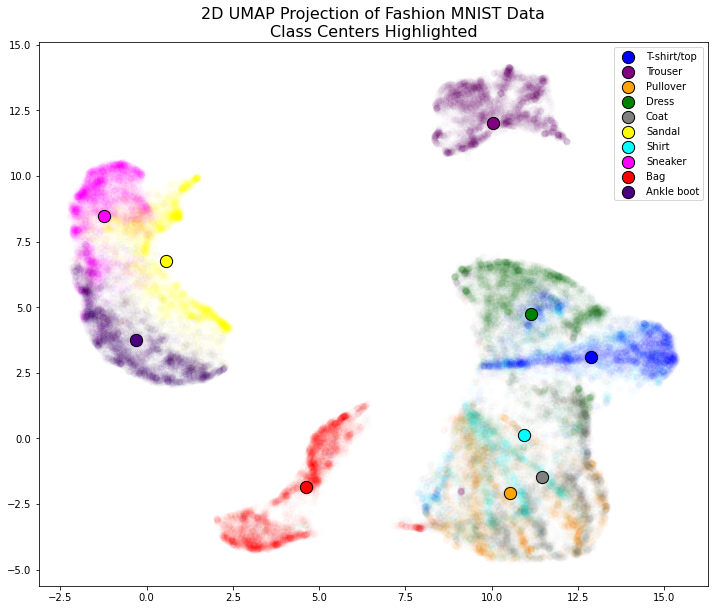

In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(x_umap[:, 0], x_umap[:, 1], alpha=0.01, c=pd.Series(y_train_names).map(color_map))
for yval, (x, y) in umap_centers.items():
  plt.scatter(x, y, s=150, c=color_map[yval], edgecolors='black', label=yval)
plt.legend()
plt.title("2D UMAP Projection of Fashion MNIST Data\nClass Centers Highlighted", fontsize=16)
plt.show()

We can see that nonlinear dimensionality isolates certain classes better, such as trousers and bags. This aligns with intuition, since these classes are each quite dissimilar from the other categories.

UMAP also highlights the relative similarities between certain clusters: the group containing footwear (sneakers, sandals, and ankle boots) are close together, with each class somewhat contained into its own sub-group (i.e. relatively little overlap between groups). On the other hand, there is another cluster containing tops, shirts, coats, pullovers, and dresses; the intra-cluster spread and overlap between classes could indicate some degree of difficulty for our classification task.